<a href="https://colab.research.google.com/github/azimi99/ML-portfolio/blob/main/Assignment4_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
Alireza Azimi



# README
Please run the cells in order

In [ ]:
!pip install gymnasium
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import argparse
import os
import random
import time
from distutils.util import strtobool

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from typing import List, Optional, Dict, Any, NamedTuple
from stable_baselines3.common.type_aliases import (
    DictReplayBufferSamples,
    DictRolloutBufferSamples,
    ReplayBufferSamples,
    RolloutBufferSamples,
)
from stable_baselines3.common.vec_env import VecNormalize
import matplotlib.pyplot as plt
import glob
from IPython.display import Video

# Implementing Custom Replay Buffer To Handle pi_old(a|s)

In [ ]:
# Credit: https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/buffers.py
class ReplayBufferSamples(NamedTuple):
    observations: torch.Tensor
    actions: torch.Tensor
    next_observations: torch.Tensor
    dones: torch.Tensor
    rewards: torch.Tensor
    old_pis: torch.Tensor

class CustomReplayBuffer(ReplayBuffer):
    def __init__(self, buffer_size, observation_space, action_space):
        super(CustomReplayBuffer, self).__init__(buffer_size, observation_space, action_space,  handle_timeout_termination=False)
        self.old_pis = np.zeros(
            (self.buffer_size, self.n_envs), dtype=float
        )

    def add(
        self,
        obs: np.ndarray,
        next_obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        done: np.ndarray,
        infos: List[Dict[str, Any]],
        old_p,
    ) -> None:
        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs, *self.obs_shape))
            next_obs = next_obs.reshape((self.n_envs, *self.obs_shape))

        # Reshape to handle multi-dim and discrete action spaces, see GH #970 #1392
        action = action.reshape((self.n_envs, self.action_dim))

        # Copy to avoid modification by reference
        self.observations[self.pos] = np.array(obs)

        if self.optimize_memory_usage:
            self.observations[(self.pos + 1) % self.buffer_size] = np.array(next_obs)
        else:
            self.next_observations[self.pos] = np.array(next_obs)

        self.actions[self.pos] = np.array(action)
        self.old_pis[self.pos] = old_p
        self.rewards[self.pos] = np.array(reward)
        self.dones[self.pos] = np.array(done)

        if self.handle_timeout_termination:
            self.timeouts[self.pos] = np.array([info.get("TimeLimit.truncated", False) for info in infos])

        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True
            self.pos = 0
    def sample(self, batch_size: int, env: Optional[VecNormalize] = None) -> ReplayBufferSamples:
        """
        Sample elements from the replay buffer.
        Custom sampling when using memory efficient variant,
        as we should not sample the element with index `self.pos`
        See https://github.com/DLR-RM/stable-baselines3/pull/28#issuecomment-637559274

        :param batch_size: Number of element to sample
        :param env: associated gym VecEnv
            to normalize the observations/rewards when sampling
        :return:
        """
        if not self.optimize_memory_usage:
            return super().sample(batch_size=batch_size, env=env)
        # Do not sample the element with index `self.pos` as the transitions is invalid
        # (we use only one array to store `obs` and `next_obs`)
        if self.full:
            batch_inds = (np.random.randint(1, self.buffer_size, size=batch_size) + self.pos) % self.buffer_size
        else:
            batch_inds = np.random.randint(0, self.pos, size=batch_size)
        return self._get_samples(batch_inds, env=env)

    def _get_samples(self, batch_inds: np.ndarray, env: Optional[VecNormalize] = None) -> ReplayBufferSamples:
        # Sample randomly the env idx
        env_indices = np.random.randint(0, high=self.n_envs, size=(len(batch_inds),))

        if self.optimize_memory_usage:
            next_obs = self._normalize_obs(self.observations[(batch_inds + 1) % self.buffer_size, env_indices, :], env)
        else:
            next_obs = self._normalize_obs(self.next_observations[batch_inds, env_indices, :], env)

        data = (
            self._normalize_obs(self.observations[batch_inds, env_indices, :], env),
            self.actions[batch_inds, env_indices, :],
            next_obs,
            # Only use dones that are not due to timeouts
            # deactivated by default (timeouts is initialized as an array of False)
            (self.dones[batch_inds, env_indices] * (1 - self.timeouts[batch_inds, env_indices])).reshape(-1, 1),
            self._normalize_reward(self.rewards[batch_inds, env_indices].reshape(-1, 1), env),
            self.old_pis[batch_inds, env_indices],
        )
        return ReplayBufferSamples(*tuple(map(self.to_torch, data)))

In [ ]:
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env

    return thunk


# ALGO LOGIC: initialize agent here:
class SoftVNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_out = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_logits = self.fc_out(x)
        return action_logits
    def get_action(self, x):
        policy_logits = actor.forward(x)
        policy_dist = F.softmax(policy_logits, dim=-1)
        # print(policy_dist.shape)
        action = torch.multinomial(policy_dist, 1)
        return action, policy_dist, policy_logits


In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/sac/#sac_continuous_actionpy

if __name__ == "__main__":
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1"
"""
        )
    writer = SummaryWriter(f"runs/CartPole")
    EXPERIMENT_SEED = 3
    # TRY NOT TO MODIFY: seeding
    random.seed(EXPERIMENT_SEED)
    np.random.seed(EXPERIMENT_SEED)
    torch.manual_seed(EXPERIMENT_SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # env setup
    envs = gym.vector.SyncVectorEnv([make_env("CartPole-v1", 10, 0, True, "run 1")]) # The environment used is CartPole pole balancing

    actor = Actor(envs).to(device)
    vf = SoftVNetwork(envs).to(device)

    v_optimizer = optim.Adam(list(vf.parameters()), lr=0.001)
    actor_optimizer = optim.Adam(list(actor.parameters()), lr=0.00005)

    envs.single_observation_space.dtype = np.float32
    rb = CustomReplayBuffer(
        1000000,
        envs.single_observation_space,
        envs.single_action_space,
    )
    start_time = time.time()
    BATCH_SIZE = 256
    GAMMA = 0.99
    episodic_returns = []
    vf_losses = []
    actor_losses = []
    MAX_STEP = 40000
    POLICY_FREQUENCY = 5
    # TRY NOT TO MODIFY: start the game
    obs, _ = envs.reset(seed=EXPERIMENT_SEED)
    for global_step in range(MAX_STEP):
        # ALGO LOGIC: put action logic here
        action, action_probs,_ = actor.get_action(torch.Tensor(obs).to(device))
        action = action.detach().cpu().numpy()

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminations, truncations, infos = envs.step(action[0])
        # # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                episodic_returns.append(info['episode']['r'])
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}, episode_length={info['episode']['l']}")
                break

        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, trunc in enumerate(truncations):
            if trunc:
                real_next_obs[idx] = infos["final_observation"][idx]


        rb.add(obs, next_obs, action, rewards, terminations, infos, action_probs[0][action[0]].item())
        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs
        # ALGO LOGIC: training.
        if global_step > 20:
            data = rb.sample(BATCH_SIZE)
            with torch.no_grad():
              next_values = data.rewards + GAMMA * vf.forward(data.next_observations) * (1-data.dones)

            current_values_grad = vf.forward(data.observations)
            vf_loss = F.mse_loss(next_values, current_values_grad)

            # optimize the model
            v_optimizer.zero_grad()
            vf_loss.backward()
            v_optimizer.step()

            if global_step % POLICY_FREQUENCY == 0:  # TD 3 Delayed update support
                actor_loss_global = 0
                for _ in range(
                    POLICY_FREQUENCY
                ):  # compensate for the delay by doing 'actor_update_interval' instead of 1
                    # Policy Gradient Update
                    objective = (data.rewards + GAMMA * vf.forward(data.next_observations).detach()\
                                 * (1 - data.dones)) - vf.forward(data.observations).detach()
                    _, prob_tensor, _ = actor.get_action(data.observations)
                    current_probs = torch.gather(prob_tensor, 1, data.actions.view(-1, 1))

                    sampling_corrections = (current_probs.squeeze())/data.old_pis
                    actor_loss = -torch.mean(sampling_corrections * objective)
                    actor_optimizer.zero_grad()
                    actor_loss.backward()
                    actor_optimizer.step()
                    actor_loss_global = actor_loss.item()
                actor_losses.append(actor_loss_global)
            if global_step % 10 == 0:
                writer.add_scalar("losses/vf_loss", vf_loss.item(), global_step)
                vf_losses.append(vf_loss.item())
    envs.close()
    writer.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Moviepy - Building video /content/videos/run 1/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/run 1/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/run 1/rl-video-episode-0.mp4
global_step=12, episodic_return=[13.], episode_length=[13]
Moviepy - Building video /content/videos/run 1/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/run 1/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/run 1/rl-video-episode-1.mp4
global_step=43, episodic_return=[31.], episode_length=[31]


global_step=61, episodic_return=[18.], episode_length=[18]
global_step=74, episodic_return=[13.], episode_length=[13]
global_step=83, episodic_return=[9.], episode_length=[9]
global_step=100, episodic_return=[17.], episode_length=[17]
global_step=116, episodic_return=[16.], episode_length=[16]
global_step=131, episodic_return=[15.], episode_length=[15]
Moviepy - Building video /content/videos/run 1/rl-video-episode-8.mp4.
Moviepy - Writing video /content/videos/run 1/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/run 1/rl-video-episode-8.mp4
global_step=150, episodic_return=[19.], episode_length=[19]


global_step=163, episodic_return=[13.], episode_length=[13]
global_step=175, episodic_return=[12.], episode_length=[12]
global_step=191, episodic_return=[16.], episode_length=[16]
global_step=210, episodic_return=[19.], episode_length=[19]
global_step=220, episodic_return=[10.], episode_length=[10]
global_step=233, episodic_return=[13.], episode_length=[13]
global_step=272, episodic_return=[39.], episode_length=[39]
global_step=325, episodic_return=[53.], episode_length=[53]
global_step=349, episodic_return=[24.], episode_length=[24]
global_step=375, episodic_return=[26.], episode_length=[26]
global_step=394, episodic_return=[19.], episode_length=[19]
global_step=409, episodic_return=[15.], episode_length=[15]
global_step=430, episodic_return=[21.], episode_length=[21]
global_step=472, episodic_return=[42.], episode_length=[42]
global_step=489, episodic_return=[17.], episode_length=[17]
global_step=520, episodic_return=[31.], episode_length=[31]
global_step=540, episodic_return=[20.], 

Moviepy - Done !
Moviepy - video ready /content/videos/run 1/rl-video-episode-27.mp4
global_step=586, episodic_return=[11.], episode_length=[11]


global_step=611, episodic_return=[25.], episode_length=[25]
global_step=624, episodic_return=[13.], episode_length=[13]
global_step=646, episodic_return=[22.], episode_length=[22]
global_step=666, episodic_return=[20.], episode_length=[20]
global_step=702, episodic_return=[36.], episode_length=[36]
global_step=730, episodic_return=[28.], episode_length=[28]
global_step=748, episodic_return=[18.], episode_length=[18]
global_step=772, episodic_return=[24.], episode_length=[24]
global_step=786, episodic_return=[14.], episode_length=[14]
global_step=867, episodic_return=[81.], episode_length=[81]
global_step=882, episodic_return=[15.], episode_length=[15]
global_step=912, episodic_return=[30.], episode_length=[30]
global_step=942, episodic_return=[30.], episode_length=[30]
global_step=967, episodic_return=[25.], episode_length=[25]
global_step=987, episodic_return=[20.], episode_length=[20]
global_step=1036, episodic_return=[49.], episode_length=[49]
global_step=1053, episodic_return=[17.]

Moviepy - Done !
Moviepy - video ready /content/videos/run 1/rl-video-episode-64.mp4
global_step=1625, episodic_return=[26.], episode_length=[26]
global_step=1667, episodic_return=[42.], episode_length=[42]
global_step=1707, episodic_return=[40.], episode_length=[40]
global_step=1738, episodic_return=[31.], episode_length=[31]
global_step=1763, episodic_return=[25.], episode_length=[25]
global_step=1805, episodic_return=[42.], episode_length=[42]
global_step=1846, episodic_return=[41.], episode_length=[41]
global_step=1886, episodic_return=[40.], episode_length=[40]
global_step=1915, episodic_return=[29.], episode_length=[29]
global_step=1952, episodic_return=[37.], episode_length=[37]
global_step=2060, episodic_return=[108.], episode_length=[108]
global_step=2100, episodic_return=[40.], episode_length=[40]
global_step=2143, episodic_return=[43.], episode_length=[43]
global_step=2215, episodic_return=[72.], episode_length=[72]
global_step=2257, episodic_return=[42.], episode_length=[42

Moviepy - Done !
Moviepy - video ready /content/videos/run 1/rl-video-episode-125.mp4
global_step=18504, episodic_return=[500.], episode_length=[500]
global_step=19004, episodic_return=[500.], episode_length=[500]
global_step=19504, episodic_return=[500.], episode_length=[500]
global_step=20004, episodic_return=[500.], episode_length=[500]
global_step=20504, episodic_return=[500.], episode_length=[500]
global_step=21004, episodic_return=[500.], episode_length=[500]
global_step=21504, episodic_return=[500.], episode_length=[500]
global_step=22004, episodic_return=[500.], episode_length=[500]
global_step=22504, episodic_return=[500.], episode_length=[500]
global_step=23004, episodic_return=[500.], episode_length=[500]
global_step=23504, episodic_return=[500.], episode_length=[500]
global_step=24004, episodic_return=[500.], episode_length=[500]
global_step=24504, episodic_return=[500.], episode_length=[500]
global_step=25004, episodic_return=[500.], episode_length=[500]
global_step=25504,

# Video Demonstrations
In this experiment we can see the agent initially struggles to balance the poll and therefore the episodes end quickly.

Here's the video for the first episode (episode 0)

In [ ]:
Video("videos/run 1/rl-video-episode-0.mp4", embed=True)

Here's the video for the second episode (episode 1)

In [ ]:
Video("videos/run 1/rl-video-episode-1.mp4", embed=True)

## The agent learns eventually
The agent will continue to optimize it's policy and value functions. Eventually max episode length is achieved (500 steps).

The following video demonstrates episode 125 where the agent achieves 500 steps.

In [ ]:
Video("videos/run 1/rl-video-episode-125.mp4", embed=True)

# Learning Plots For Single Run

Text(0, 0.5, 'Episodic Return')

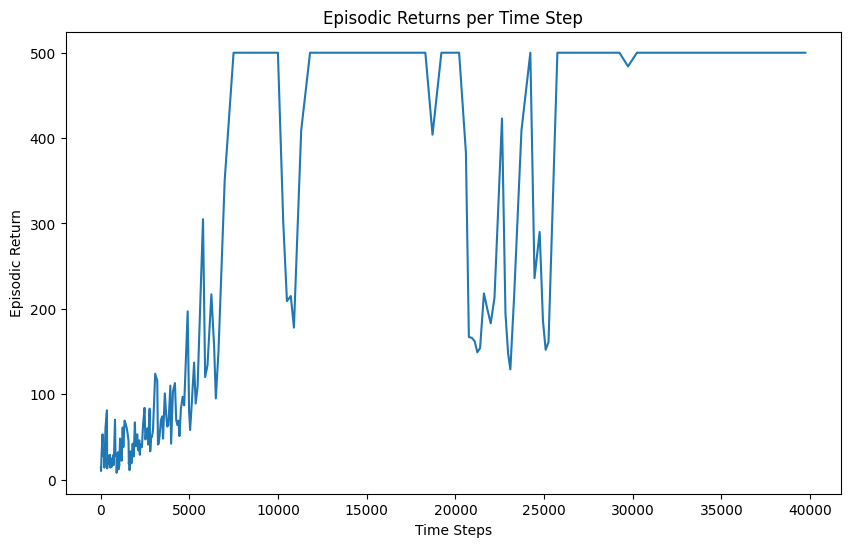

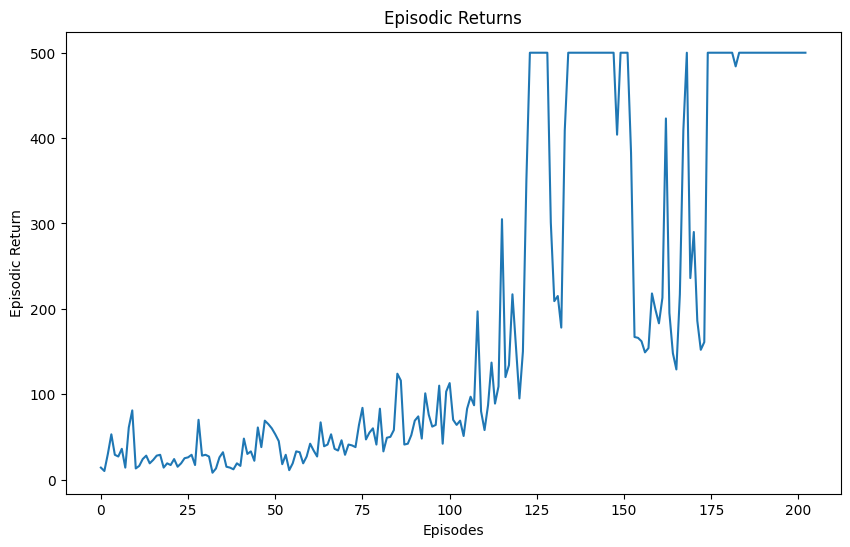

In [ ]:
# Plotting the episodic returns over the length of the experiment
plt.figure(figsize=(10, 6))
x = np.cumsum(episodic_returns)
plt.plot(x, episodic_returns, label='Returns')
plt.title('Episodic Returns per Time Step')
plt.xlabel('Time Steps')
plt.ylabel('Episodic Return')

plt.figure(figsize=(10, 6))
x = np.cumsum(episodic_returns)
plt.plot(episodic_returns, label='Returns')
plt.title('Episodic Returns')
plt.xlabel('Episodes')
plt.ylabel('Episodic Return')


Text(0, 0.5, 'Loss')

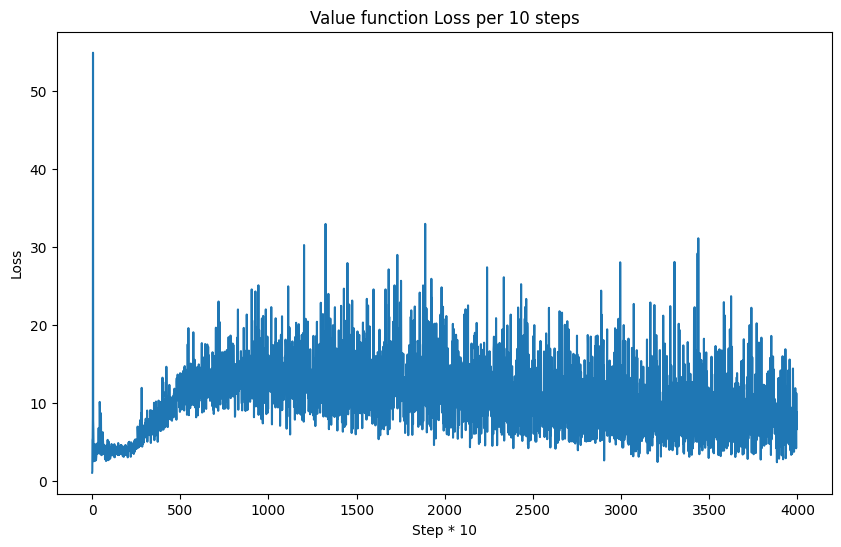

In [ ]:
# Value loss per time step as collected
plt.figure(figsize=(10, 6))
plt.plot(vf_losses, label='Value Function Loss')
plt.title('Value function Loss per 10 steps')
plt.xlabel('Step * 10')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

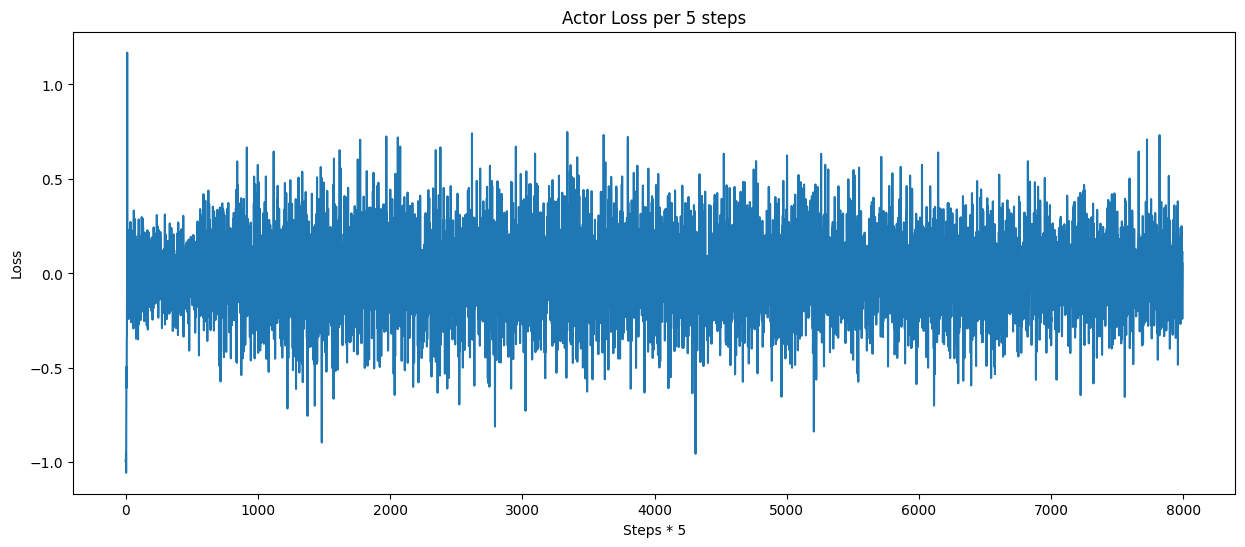

In [ ]:
# Policy Loss Per 5 Time Steps As Collected
plt.figure(figsize=(15, 6))
plt.plot(actor_losses, label='Actor Loss')
plt.title('Actor Loss per 5 steps')
plt.xlabel('Steps * 5')
plt.ylabel('Loss')

# Episodic Returns for 5 indepenedent runs


In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/sac/#sac_continuous_actionpy

if __name__ == "__main__":
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1"
"""
        )
    SEED_VALUES = [3,4,5,6,7]
    run_episodic_returns = []
    for index, s in enumerate(SEED_VALUES):
      print(f"Run #{index+1} Has Started. Using Seed: {s}")
      writer = SummaryWriter(f"runs/CartPole")
      EXPERIMENT_SEED = s
      # TRY NOT TO MODIFY: seeding
      random.seed(EXPERIMENT_SEED)
      np.random.seed(EXPERIMENT_SEED)
      torch.manual_seed(EXPERIMENT_SEED)
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # env setup
      envs = gym.vector.SyncVectorEnv([make_env("CartPole-v1", 10, 0, False, "run "+str((index+1)))]) # The environment used is CartPole pole balancing

      actor = Actor(envs).to(device)
      vf = SoftVNetwork(envs).to(device)

      v_optimizer = optim.Adam(list(vf.parameters()), lr=0.001)
      actor_optimizer = optim.Adam(list(actor.parameters()), lr=0.00005)

      envs.single_observation_space.dtype = np.float32
      rb = CustomReplayBuffer(
          1000000,
          envs.single_observation_space,
          envs.single_action_space,
      )
      start_time = time.time()
      BATCH_SIZE = 256
      GAMMA = 0.99
      episodic_returns = []
      # vf_losses = []
      # actor_losses = []
      MAX_STEP = 40000
      POLICY_FREQUENCY = 5
      # TRY NOT TO MODIFY: start the game
      obs, _ = envs.reset(seed=EXPERIMENT_SEED)
      for global_step in range(MAX_STEP):
          # ALGO LOGIC: put action logic here
          action, action_probs,_ = actor.get_action(torch.Tensor(obs).to(device))
          action = action.detach().cpu().numpy()

          # TRY NOT TO MODIFY: execute the game and log data.
          next_obs, rewards, terminations, truncations, infos = envs.step(action[0])
          # # TRY NOT TO MODIFY: record rewards for plotting purposes
          if "final_info" in infos:
              for info in infos["final_info"]:
                  episodic_returns.append(info['episode']['r'])
                  # print(f"global_step={global_step}, episodic_return={info['episode']['r']}, episode_length={info['episode']['l']}") #-- No need to print
                  break

          # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
          real_next_obs = next_obs.copy()
          for idx, trunc in enumerate(truncations):
              if trunc:
                  real_next_obs[idx] = infos["final_observation"][idx]


          rb.add(obs, next_obs, action, rewards, terminations, infos, action_probs[0][action[0]].item())
          # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
          obs = next_obs
          # ALGO LOGIC: training.
          if global_step > 20:
              data = rb.sample(BATCH_SIZE)
              with torch.no_grad():
                next_values = data.rewards + GAMMA * vf.forward(data.next_observations) * (1-data.dones)

              current_values_grad = vf.forward(data.observations)
              vf_loss = F.mse_loss(next_values, current_values_grad)

              # optimize the model
              v_optimizer.zero_grad()
              vf_loss.backward()
              v_optimizer.step()

              if global_step % POLICY_FREQUENCY == 0:  # TD 3 Delayed update support
                  # actor_loss_global = 0 -- Not Needed
                  for _ in range(
                      POLICY_FREQUENCY
                  ):  # compensate for the delay by doing 'actor_update_interval' instead of 1
                      # Policy Gradient Update
                      objective = (data.rewards + GAMMA * vf.forward(data.next_observations).detach()\
                                  * (1 - data.dones)) - vf.forward(data.observations).detach()
                      _, prob_tensor, _ = actor.get_action(data.observations)
                      current_probs = torch.gather(prob_tensor, 1, data.actions.view(-1, 1))

                      sampling_corrections = (current_probs.squeeze())/data.old_pis
                      actor_loss = -torch.mean(sampling_corrections * objective)
                      actor_optimizer.zero_grad()
                      actor_loss.backward()
                      actor_optimizer.step()

      run_episodic_returns.append(episodic_returns)
      print("Run Has Completed.")
      envs.close()
      writer.close()

Run #1 Has Started. Using Seed: 3
Run Has Completed.
Run #2 Has Started. Using Seed: 4
Run Has Completed.
Run #3 Has Started. Using Seed: 5
Run Has Completed.
Run #4 Has Started. Using Seed: 6
Run Has Completed.
Run #5 Has Started. Using Seed: 7
Run Has Completed.


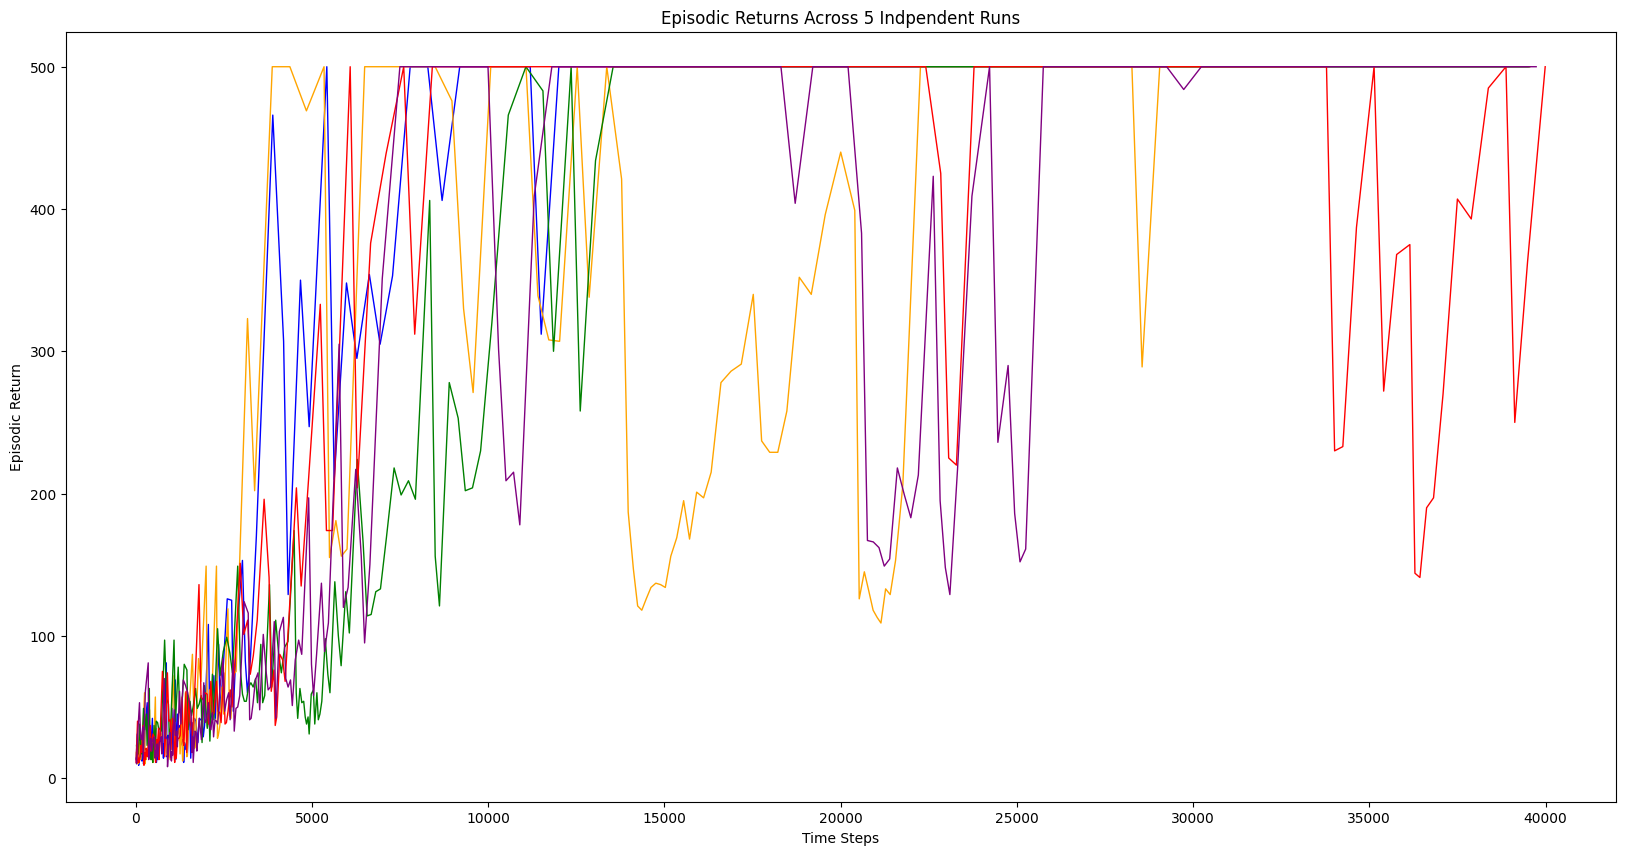

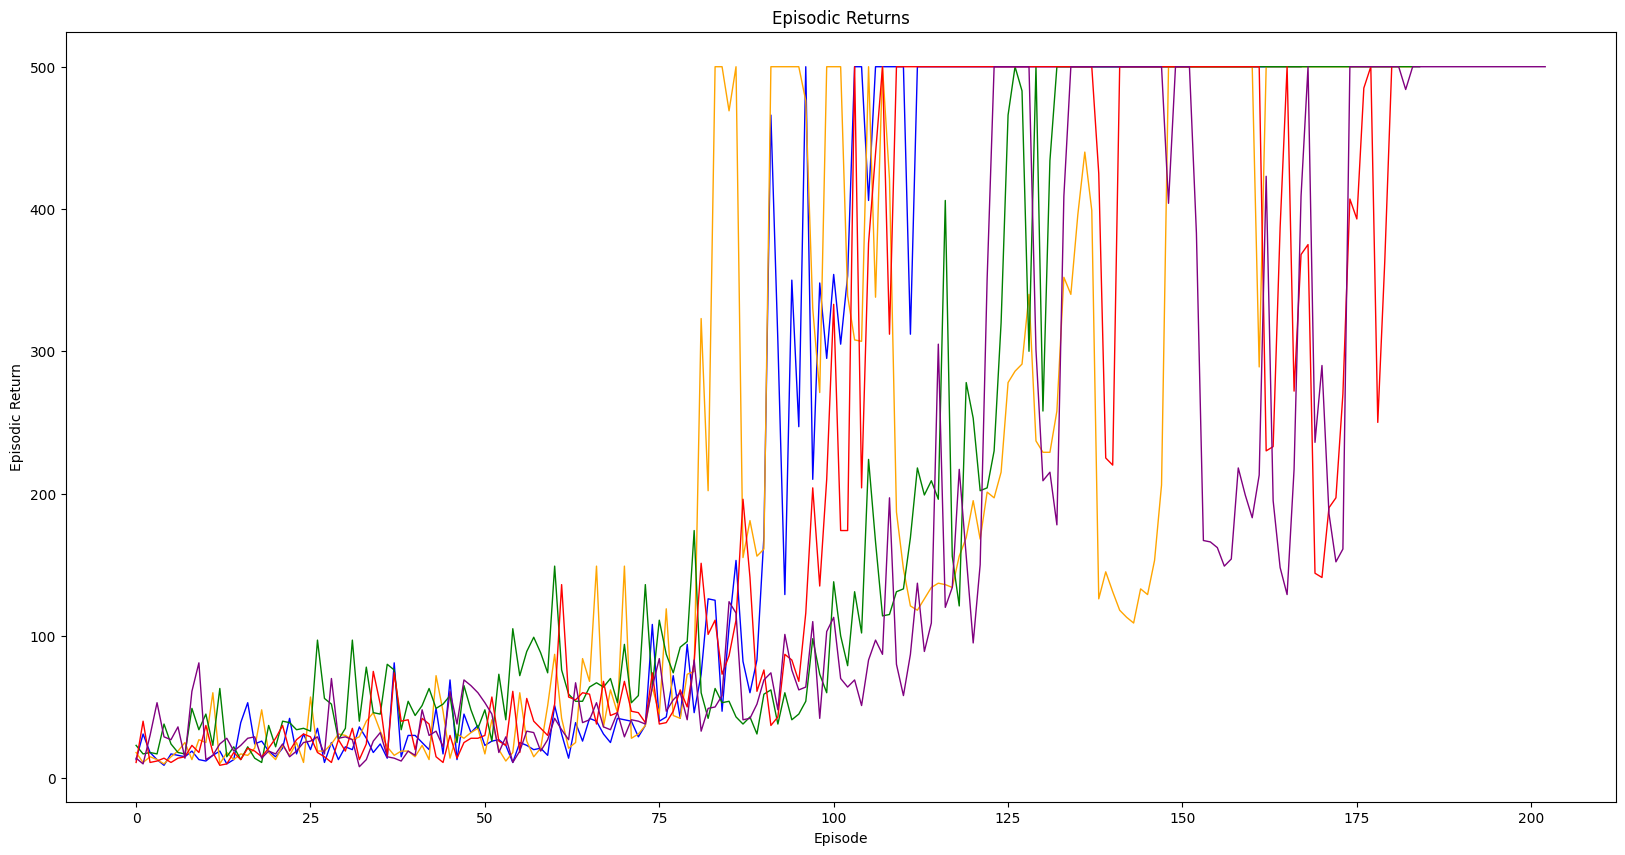

In [ ]:
colors_list = ['blue', 'orange', 'green', 'red', 'purple']
plt.figure(figsize=(20,10))
for index, run in enumerate(run_episodic_returns):
  x = np.cumsum(run)
  plt.plot(x, run, linewidth=1, color=colors_list[index])
plt.title("Episodic Returns Across 5 Indpendent Runs")
plt.ylabel("Episodic Return")
plt.xlabel("Time Steps")
plt.figure(figsize=(20,10))
for index, run in enumerate(run_episodic_returns):
  plt.plot(run, linewidth=1, color=colors_list[index])
plt.title("Episodic Returns")
plt.ylabel("Episodic Return")
plt.xlabel("Episode")
plt.show()